In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# Load the Iris dataset
iris=datasets.load_iris()
X=iris.data
y=iris.target

# Split the dataset into a training set and a testing set (70% training, 30% testing)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
from sklearn.metrics import pairwise_distances

# For simplicity, we'll use Euclidean distance as the distance metric
distances=pairwise_distances(X_test,X_train,metric='euclidean')
import numpy as np

def find_k_nearest_neighbors(distances,k):
    k_nearest_neighbors_indices=np.argsort(distances,axis=1)[:,:k]
    return k_nearest_neighbors_indices

k=5
k_nearest_neighbors_indices=find_k_nearest_neighbors(distances,k)

from scipy.stats import mode

def predict_majority_class(k_nearest_neighbors_indices, y_train):
    k_nearest_classes=y_train[k_nearest_neighbors_indices]
    predictions,_=mode(k_nearest_classes,axis=1)
    return predictions.ravel()

y_pred=predict_majority_class(k_nearest_neighbors_indices,y_train)

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
accuracy=accuracy_score(y_test,y_pred)
print("Accuracy:",accuracy)

print("\nClassification Report:")
print(classification_report(y_test,y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test,y_pred))


Accuracy: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


Confusion Matrix:
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


In [2]:
import pandas as pd

df = pd.read_csv("./golf_data.csv")
print("\n Given Play Golf Dataset:\n\n", df)


 Given Play Golf Dataset:

      Outlook Temperature Humidity    Wind PlayGolf
0      Rainy         Hot     High    Weak       No
1      Rainy         Hot     High  Strong       No
2   Overcast         Hot     High    Weak      Yes
3      Sunny        Mild     High    Weak      Yes
4      Sunny        Cool   Normal    Weak      Yes
5      Sunny        Cool   Normal  Strong       No
6   Overcast        Cool   Normal  Strong      Yes
7      Rainy        Mild     High    Weak       No
8      Rainy        Cool   Normal    Weak      Yes
9      Sunny        Mild   Normal    Weak      Yes
10     Rainy        Mild   Normal  Strong      Yes
11  Overcast        Mild     High  Strong      Yes
12  Overcast         Hot   Normal    Weak      Yes
13     Sunny        Mild     High  Strong       No


In [3]:
t = df.keys()[-1]
print('Target Attribute is   ➡ ', t)

# Get the attribute names from input dataset
attribute_names = list(df.keys())

#Remove the target attribute from the attribute names list
attribute_names.remove(t) 

print('Predicting Attributes ➡ ', attribute_names)

Target Attribute is   ➡  PlayGolf
Predicting Attributes ➡  ['Outlook', 'Temperature', 'Humidity', 'Wind']


In [4]:
#Function to calculate the entropy of probaility of observations
# -p*log2*p

import math
def entropy(probs):  
    return sum( [-prob*math.log(prob, 2) for prob in probs])

#Function to calulate the entropy of the given Datasets/List with respect to target attributes
def entropy_of_list(ls,value):  
    from collections import Counter
    
    # Total intances associated with respective attribute
    total_instances = len(ls)  # = 14
    print("---------------------------------------------------------")
    print("\nTotal no of instances/records associated with '{0}' is ➡ {1}".format(value,total_instances))
    # Counter calculates the propotion of class
    cnt = Counter(x for x in ls)
    print('\nTarget attribute class count(Yes/No)=',dict(cnt))
    
    # x means no of YES/NO
    probs = [x / total_instances for x in cnt.values()]  
    print("\nClasses➡", max(cnt), min(cnt))
    print("\nProbabilities of Class 'p'='{0}' ➡ {1}".format(max(cnt),max(probs)))
    print("Probabilities of Class 'n'='{0}'  ➡ {1}".format(min(cnt),min(probs)))
    
    # Call Entropy 
    return entropy(probs) 

In [5]:
def information_gain(df, split_attribute, target_attribute,battr):
    print("\n\n----- Information Gain Calculation of",split_attribute,"----- ") 
    
    # group the data based on attribute values
    df_split = df.groupby(split_attribute) 
    glist=[]
    for gname,group in df_split:
        print('Grouped Attribute Values \n',group)
        print("---------------------------------------------------------")
        glist.append(gname) 
    
    glist.reverse()
    nobs = len(df.index) * 1.0   
    df_agg1=df_split.agg({target_attribute:lambda x:entropy_of_list(x, glist.pop())})
    df_agg2=df_split.agg({target_attribute :lambda x:len(x)/nobs})
    
    df_agg1.columns=['Entropy']
    df_agg2.columns=['Proportion']
    
    # Calculate Information Gain:
    new_entropy = sum( df_agg1['Entropy'] * df_agg2['Proportion'])
    if battr !='S':
        old_entropy = entropy_of_list(df[target_attribute],'S-'+df.iloc[0][df.columns.get_loc(battr)])
    else:
        old_entropy = entropy_of_list(df[target_attribute],battr)
    return old_entropy - new_entropy

In [6]:
def id3(df, target_attribute, attribute_names, default_class=None,default_attr='S'):
    
    from collections import Counter
    cnt = Counter(x for x in df[target_attribute])# class of YES /NO
    
    ## First check: Is this split of the dataset homogeneous?
    if len(cnt) == 1:
        return next(iter(cnt))  # next input data set, or raises StopIteration when EOF is hit.
    
    ## Second check: Is this split of the dataset empty? if yes, return a default value
    elif df.empty or (not attribute_names):
        return default_class  # Return None for Empty Data Set
    
    ## Otherwise: This dataset is ready to be devied up!
    else:
        # Get Default Value for next recursive call of this function:
        default_class = max(cnt.keys()) #No of YES and NO Class
        # Compute the Information Gain of the attributes:
        gainz=[]
        for attr in attribute_names:
            ig= information_gain(df, attr, target_attribute,default_attr)
            gainz.append(ig)
            print('\nInformation gain of','“',attr,'”','is ➡', ig)
            print("=========================================================")
        
        index_of_max = gainz.index(max(gainz))               # Index of Best Attribute
        best_attr = attribute_names[index_of_max]            # Choose Best Attribute to split on
        print("\nList of Gain for arrtibutes:",attribute_names,"\nare:", gainz,"respectively.")
        print("\nAttribute with the maximum gain is ➡", best_attr)
        print("\nHence, the Root node will be ➡", best_attr)
        print("=========================================================")

        # Create an empty tree, to be populated in a moment
        tree = {best_attr:{}} # Initiate the tree with best attribute as a node 
        remaining_attribute_names =[i for i in attribute_names if i != best_attr]
        
        # Split dataset-On each split, recursively call this algorithm.Populate the empty tree with subtrees, which
        # are the result of the recursive call
        for attr_val, data_subset in df.groupby(best_attr):
            subtree = id3(data_subset,target_attribute, remaining_attribute_names,default_class,best_attr)
            tree[best_attr][attr_val] = subtree
        return tree

In [7]:
#Function to calulate the entropy of the given Dataset with respect to target attributes
def entropy_dataset(a_list):  
    from collections import Counter

    # Counter calculates the propotion of class
    cnt = Counter(x for x in a_list)   
    num_instances = len(a_list)*1.0    # = 14
    print("\nNumber of Instances of the Current Sub-Class is {0}".format(num_instances ))
    
    # x means no of YES/NO
    probs = [x / num_instances for x in cnt.values()]  
    print("\nClasses➡", "'p'=",max(cnt), "'n'=",min(cnt))
    print("\nProbabilities of Class 'p'='{0}' ➡ {1}".format(max(cnt),max(probs)))
    print("Probabilities of Class 'n'='{0}'  ➡ {1}".format(min(cnt),min(probs)))
    
    # Call Entropy
    return entropy(probs) 
    
# The initial entropy of the YES/NO attribute for our dataset.
print("Entropy calculation for input dataset:\n")
print(df['PlayGolf'])

total_entropy = entropy_dataset(df['PlayGolf'])
print("\nTotal Entropy(S) of PlayGolf Dataset➡", total_entropy)
print("=========================================================")
####################################################

from pprint import pprint
tree = id3(df,t,attribute_names)
print("\nThe Resultant Decision Tree is: ⤵\n")
pprint(tree)

attribute = next(iter(tree))
print("\nBest Attribute ➡",attribute)
print("Tree Keys      ➡",tree[attribute].keys())

Entropy calculation for input dataset:

0      No
1      No
2     Yes
3     Yes
4     Yes
5      No
6     Yes
7      No
8     Yes
9     Yes
10    Yes
11    Yes
12    Yes
13     No
Name: PlayGolf, dtype: object

Number of Instances of the Current Sub-Class is 14.0

Classes➡ 'p'= Yes 'n'= No

Probabilities of Class 'p'='Yes' ➡ 0.6428571428571429
Probabilities of Class 'n'='No'  ➡ 0.35714285714285715

Total Entropy(S) of PlayGolf Dataset➡ 0.9402859586706309


----- Information Gain Calculation of Outlook ----- 
Grouped Attribute Values 
      Outlook Temperature Humidity    Wind PlayGolf
2   Overcast         Hot     High    Weak      Yes
6   Overcast        Cool   Normal  Strong      Yes
11  Overcast        Mild     High  Strong      Yes
12  Overcast         Hot   Normal    Weak      Yes
---------------------------------------------------------
Grouped Attribute Values 
    Outlook Temperature Humidity    Wind PlayGolf
0    Rainy         Hot     High    Weak       No
1    Rainy         Ho

IndexError: pop from empty list

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO 
from sklearn.tree import export_graphviz
import graphviz

import warnings
warnings.filterwarnings("ignore")

iris = pd.read_csv("iris.csv")
iris

,sepallength,sepalwidth,petallength,petalwidth,classes
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [9]:
classes = iris['classes'].unique().tolist()
classes

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [10]:
# Putting feature variable to X
X = iris.drop('classes',axis=1)

# Putting response variable to y
y = iris['classes']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.30, 
                                                    random_state = 99)
X_train.head()

,sepallength,sepalwidth,petallength,petalwidth
10,5.4,3.7,1.5,0.2
25,5.0,3.0,1.6,0.2
13,4.3,3.0,1.1,0.1
131,7.9,3.8,6.4,2.0
65,6.7,3.1,4.4,1.4


In [12]:
dt_iris = DecisionTreeClassifier()
dt_iris.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [13]:
y_pred_train = dt_iris.predict(X_train)

print(classification_report(y_train, y_pred_train))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        38
Iris-versicolor       1.00      1.00      1.00        32
 Iris-virginica       1.00      1.00      1.00        35

       accuracy                           1.00       105
      macro avg       1.00      1.00      1.00       105
   weighted avg       1.00      1.00      1.00       105



In [14]:
print(confusion_matrix(y_train,y_pred_train))
print(accuracy_score(y_train,y_pred_train))

[[38  0  0]
 [ 0 32  0]
 [ 0  0 35]]
1.0


In [15]:
y_pred_default = dt_iris.predict(X_test)

print(classification_report(y_test, y_pred_default))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        12
Iris-versicolor       0.94      0.94      0.94        18
 Iris-virginica       0.93      0.93      0.93        15

       accuracy                           0.96        45
      macro avg       0.96      0.96      0.96        45
   weighted avg       0.96      0.96      0.96        45



In [16]:
print(confusion_matrix(y_test,y_pred_default))
print(accuracy_score(y_test,y_pred_default))

[[12  0  0]
 [ 0 17  1]
 [ 0  1 14]]
0.9555555555555556


In [21]:
!pip install  pydotplus

     |████████████████████████████████| 278 kB 1.1 MB/s eta 0:00:01
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24554 sha256=64f12cf4afc21788acc0f3e4b4302b1fb29fe2c170497d39d49d9cdc3863c211
  Stored in directory: /home/machine/.cache/pip/wheels/1e/7b/04/7387cf6cc9e48b4a96e361b0be812f0708b394b821bf8c9c50
Successfully built pydotplus


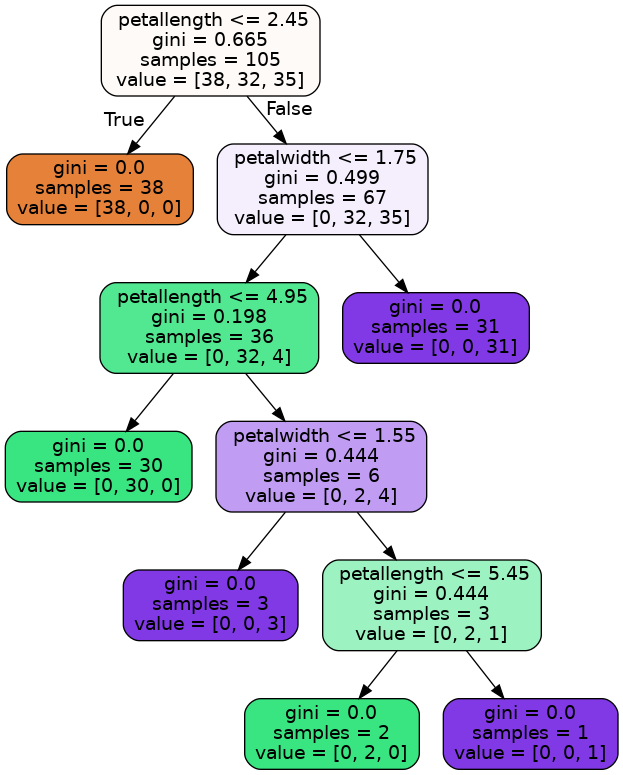

In [22]:
import pydotplus
features = list(X_train.columns)
dot_data = StringIO()  
export_graphviz(dt_iris, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [18]:
y_pred_default = dt_iris.predict([[5.2,3.1,1.4,0.2]])

y_pred_default

array(['Iris-setosa'], dtype=object)